In [1]:
#!/usr/bin/env python

import os
import random
from imgcat import imgcat
from math import sqrt
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

from cube import Cube

In [2]:
class Cube:
    def __init__(self, x=0, y=0, z=0):
        if (x+y+z == 0):
            self.x = x
            self.y = y
            self.z = z
        else:
            raise ValueError('x,y,z: '+','.join((str(x),str(y),str(z))))
            
    
    def add(self, other):
        return Cube(self.x+other.x, self.y+other.y, self.z+other.z)
        
    def sub(self, other):
        return Cube(self.x-other.x, self.y-other.y, self.z-other.z)
        
    def mag(self):
        return max(abs(self.x), abs(self.y), abs(self.z))

    def nbr(self, other):
        return self.sub(other).mag() == 1

    def dot(self, other):
        return (self.x * other.x + self.y * other.y + self.z * other.z)
    
    def dist(self, other):
        return max(abs(self.x-other.x), abs(self.y-other.y), abs(self.z-other.z))

    def avg(self, other):
        x = (self.x+other.x)//2
        y = (self.y+other.y)//2
        return Cube(x, y, -x-y)
    
    def add_in_place(self, other):
        self.x = self.x+other.x
        self.y = self.y+other.y
        self.z = self.z+other.z
        
    def rotate_right(self, num):
        if num % 6 == 0:
            return Cube(self.x, self.y, self.z)
        if num % 6 == 1:
            return Cube(-self.z, -self.x, -self.y)
        elif num % 6 == 2:
            return Cube( self.y,  self.z,  self.x)
        elif num % 6 == 3:
            return Cube(-self.x, -self.y, -self.z)
        elif num % 6 == 4:
            return Cube( self.z,  self.x,  self.y)
        else: #elif num % 6 == 5:
            return Cube(-self.y, -self.z, -self.x)
            
    def rotate_right_in_place(self, num):
        if num % 6 == 0:
            pass
        elif num % 6 == 1:
            (self.x,self.y,self.z) = (-self.z, -self.x, -self.y)
        elif num % 6 == 2:
            (self.x,self.y,self.z) = ( self.y,  self.z,  self.x)
        elif num % 6 == 3:
            (self.x,self.y,self.z) = (-self.x, -self.y, -self.z)
        elif num % 6 == 4:
            (self.x,self.y,self.z) = ( self.z,  self.x,  self.y)
        else: #elif num % 6 == 5:
            (self.x,self.y,self.z) = (-self.y, -self.z, -self.x)
            
    def tuple(self):
        return (self.x, self.y, self.z)

    def __str__(self):
        return str(self.x)+", "+str(self.y)+", "+str(self.z)
        
    def __repr__(self):
        return f"Cube({self.x}, {self.y}, {self.z})"

    def __le__(self, other):
        return self.mag() <= other.mag()
    
    def __lt__(self, other):
        return self.mag() < other.mag()

    def __eq__(self, other):
        if isinstance(other, Cube):
            return (self.x == other.x) and (self.y == other.y) and (self.z == other.z)
        else:
            return False
            
    def __ne__(self, other):
        return not self.__eq__(other)
        
    def __hash__(self):
        return hash(tuple((self.x, self.y, self.z)))
        
    def neighbors(self):
        return {Cube(self.x+1,self.y,self.z-1), Cube(self.x,self.y+1,self.z-1),
                Cube(self.x-1,self.y+1,self.z), Cube(self.x-1,self.y,self.z+1),
                Cube(self.x,self.y-1,self.z+1), Cube(self.x+1,self.y-1,self.z)}
        
    def ordered_neighbors(self):
        """In counterclockwise order, starting with ENE."""
        return [Cube(self.x+1,self.y,self.z-1), Cube(self.x,self.y+1,self.z-1),
                Cube(self.x-1,self.y+1,self.z), Cube(self.x-1,self.y,self.z+1),
                Cube(self.x,self.y-1,self.z+1), Cube(self.x+1,self.y-1,self.z)]
    
    def strait_neighbors(self):
        return {Cube(self.x+1,self.y-2,self.z+1), Cube(self.x-1,self.y+2,self.z-1),
                Cube(self.x+1,self.y+1,self.z-2), Cube(self.x-1,self.y-1,self.z+2),
                Cube(self.x+2,self.y-1,self.z-1), Cube(self.x-2,self.y+1,self.z+1)}

    def valid(self, other):
        '''Checks to make sure this cube is in the sector (third) defined by other.'''
        if (other.x < 0 and self.x >= 0): return False 
        if (other.x > 0 and self.x <= 0): return False 
        if (other.y < 0 and self.y >= 0): return False 
        if (other.y > 0 and self.y <= 0): return False 
        if (other.z < 0 and self.z >= 0): return False 
        if (other.z > 0 and self.z <= 0): return False 
        return True
        
    def flip(self, valid_dir):
        if valid_dir.x == 0:
            return Cube(-self.x, -self.z, -self.y)
        elif valid_dir.y == 0:
            return Cube(-self.z, -self.y, -self.x)
        elif valid_dir.z == 0:
            return Cube(-self.y, -self.x, -self.z)
        else:
            raise ValueError('Need a 0 el. x,y,z: '+','.join((str(x),str(y),str(z))))
    
    def flip_in_place(self, valid_dir):
        if valid_dir.x == 0:
            temp = self.y
            self.y = -self.z
            self.z = -temp
            self.x = -self.x
        elif valid_dir.y == 0:
            temp = self.x
            self.x = -self.z
            self.z = -temp
            self.y = -self.y
        elif valid_dir.z == 0:
            temp = self.y
            self.y = -self.x
            self.x = -temp
            self.z = -self.z
        else:
            raise ValueError('Need a 0 el. x,y,z: '+','.join((str(valid_dir.x),str(valid_dir.y),str(valid_dir.z))))

In [3]:
import matplotlib.pyplot as plt

class Doodler:
    def __init__(self, cubes_colors, size=(200,200), radius=10):
        ''' cubes is a map from (x,y,z) -> [color] '''
        self.im = Image.new('RGB', size, (0, 0, 0))
        self.draw = ImageDraw.Draw(self.im)
        self.size = size
        self.radius = radius
        for cube, color_list in cubes_colors.items():
            if isinstance(color_list, tuple) or len(color_list) == 1:
                color = color_list if isinstance(color_list, tuple) else color_list[0]
                center_pixel = self.get_center(cube)
                hex_points = self.get_hex_points(center_pixel)
                self.draw.polygon(hex_points, fill=color)
            else:
                center_pixel = self.get_center(cube)
                triangle_points = self.get_triangle_points(center_pixel)
                for triangle in range(6):
                    self.draw.polygon(triangle_points[triangle], fill=random.choice(color_list))

    @classmethod
    def random_colors(cls, hex_list, *args, **kwargs):
        random_color = lambda: tuple(np.random.randint(64, 256, size=3))
        cubes_colors = {h: random_color() for h in hex_list}
        return cls(cubes_colors=cubes_colors, *args, **kwargs)

    def get_center(self, cube):
        assert cube.x + cube.y + cube.z == 0, f'bad cube {cube}'
        p = np.array(self.size) / 2
        p += cube.x * np.array([sqrt(3), -1]) * self.radius
        p += cube.y * np.array([0, -1]) * self.radius * 2
        return p

    def get_hex_points(self, p):
        points = []
        for angle in range(0, 360, 60):
            theta = angle * np.pi / 180
            delta = np.array([np.cos(theta), np.sin(theta)]) * self.radius
            points.append(tuple(p + delta))
        return points

    def get_triangle_points(self, p):
        points = []
        for angle in range(0, 360, 60):
            theta = angle * np.pi / 180
            delta = np.array([np.cos(theta), np.sin(theta)]) * self.radius
            points.append(tuple(p + delta))
        points.append(points[0])
        point_sets = []
        for triangle in range(6):
            point_sets.append([tuple(p), points[triangle], points[triangle + 1]])
        return point_sets

    def show(self):
        plt.imshow(self.im)
        plt.show()

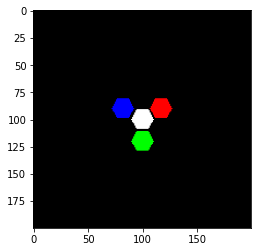

In [4]:
doodler = Doodler(dict([
    (Cube(0,0,0),(255, 255,255)),
    (Cube(1,0,-1),(255,0,0)),
    (Cube(0,-1,1),(0,255,0)),
    (Cube(-1,1,0),(0,0,255)),
]))
doodler.show()


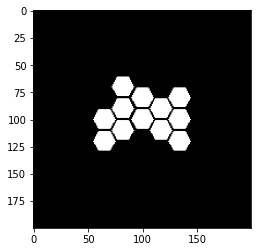

{Cube(-1, 0, 1),
 Cube(1, 0, -1),
 Cube(-1, 1, 0),
 Cube(1, -1, 0),
 Cube(0, 1, -1)}

In [5]:
# Chunk of size 12
import random

class Chunk:
    """ Contiguous chunk of cubes of a given size """

    def __init__(self, cubes):
        assert all(isinstance(c, Cube) for c in cubes), f'{cubes}'
        self.cubes = sorted(cubes)
        self._neighbors = None

    @classmethod
    def make(cls, size, seed=0):
        """ Make a contiguous chunk of a given size """
        rng = random.Random(seed)
        cubes = set([Cube()])
        while len(cubes) < size:
            c = rng.choice(list(cubes))
            n = rng.choice(list(c.neighbors()))
            cubes.add(n)
        return Chunk(cubes)

    def show(self):
        """ Render a chunk """
        Doodler({c: (255, 255, 255) for c in self.cubes}).show()

    def show_splits(self, splits):
        """ Draw a partially split chunk """
        assert len(splits) <= 3, f'only 3 colors supported for now'
        colors = (255, 0, 0), (0,255,0), (0,0,255)
        cubes = {c: (255, 255, 255) for c in self.cubes}
        for color, split in zip(colors, splits):
            for c in split:
                cubes[c] = color
        Doodler(cubes).show()

    def __len__(self):
        return len(self.cubes)

    @property
    def neighbors(self):
        """ Get a map of cube -> neighbors inside the chunk """
        if not self._neighbors:
            # N = len(self.cubes)
            # self._neighbors_matrix = np.zeros((N, N), dtype=bool)
            # for i, c in enumerate(self.cubes):
            #     for n in c.neighbors():
            #         if n in self.cubes:
            #             self._neighbors_matrix[i, self.cubes.index(n)] = True
            self._neighbors = dict()
            for c in self.cubes:
                self._neighbors[c] = set(c.neighbors()) & set(self.cubes)
        return self._neighbors

    def inner_neighbors(self, c):
        """ Get neighbors of a cube that are inside the chunk """
        assert c in self.cubes, f'{c}'
        return self.neighbors[c]

chunk = Chunk.make(12)
chunk.show()
# plt.matshow(chunk.neighbors)
# chunk.neighbors
len(chunk)
chunk.inner_neighbors(chunk.cubes[0])


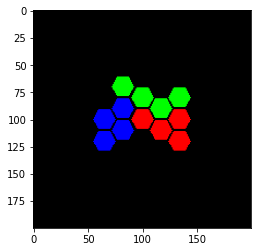

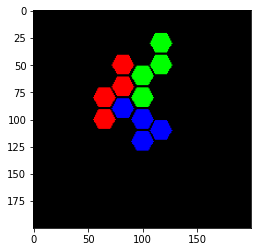

failed to find solution to split chunk


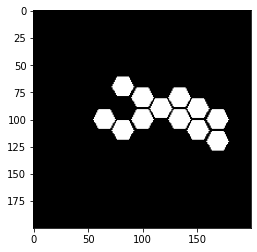

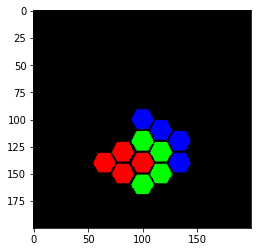

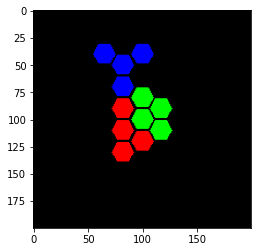

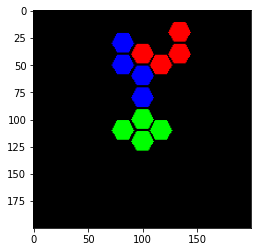

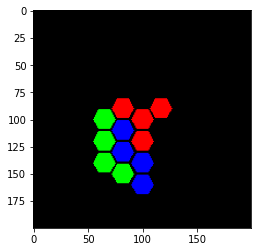

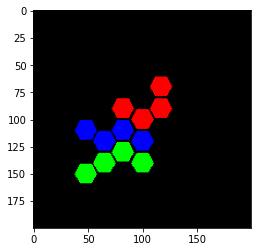

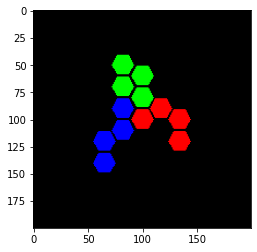

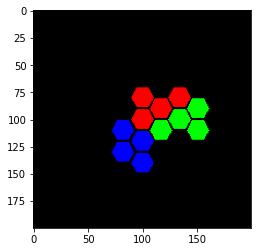

In [29]:
def split_chunk(chunk, sizes, max_iter=10000, seed=0):
    """
    Split a chunk (list of cubes) into contiguous subsets of given sizes.

    chunk - list of cubes to split
    sizes - list of sizes to split into

    Returns a list of chunks (set of cubes) that correspond to the sizes.
    """
    assert len(chunk) == sum(sizes), f'{len(chunk)} != {sum(sizes)}'
    rng = random.Random(seed)
    for _ in range(max_iter):
        result = split_chunk_iter(chunk, sizes, rng)
        if result != None:
            return result
    print('failed to find solution to split chunk')
    chunk.show()
    raise Exception('Ran out of iterations trying to split chunk')

def split_chunk_iter(chunk, sizes, rng=0):
    """ Single step of split_chunk() """
    assert len(chunk) > len(sizes), f'{len(chunk)} !> {len(sizes)}'
    if not isinstance(rng, random.Random):
        rng = random.Random(rng)
    # start by drawing three random items
    splits = [[c] for c in rng.sample(chunk.cubes, len(sizes))]
    unused = set(chunk.cubes) - set(sum(splits, []))
    # chunk.show_splits([unused])
    max_iters = max(sizes) * len(sizes) # worst case
    for j in range(max_iters):
        i = j % len(sizes)
        size = sizes[i]
        split = splits[i]
        if len(split) == size:
            continue
        # get all of the neighbors of the split
        candidates = set()
        for c in split:
            candidates |= chunk.inner_neighbors(c)
        # filter to unused cubes
        candidates = candidates & unused
        if not candidates:
            # print('failed to find candidate')
            # chunk.show_splits(splits)
            return None
        # Pick a candidate at random and add it
        choice = rng.choice(list(candidates))
        split.append(choice)
        unused.remove(choice)
    chunk.show_splits(splits)
    return splits

# split_chunk_iter(chunk, [4,4,4])
for seed in range(10):
    try:
        chunk = Chunk.make(12, seed=seed)
        split_chunk(chunk, [4,4,4], seed=seed)
    except:
        continue

{Cube(0, 0, 0), Cube(2, -2, 0), Cube(-2, 0, 2)}

In [15]:
s = set(range(3))
s.remove(1)
s

{0, 2}